In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Core Data and NLP
!pip install --upgrade nltk contractions wordcloud

# Word Embeddings
!pip install --upgrade gensim

# Gradio GUI
!pip install --upgrade gradio

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight # For calculating class weights

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Bidirectional

In [ ]:
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    WordNetLemmatizer().lemmatize('cats')
except LookupError:
    nltk.download('wordnet')
    nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df = pd.read_csv('./Hotel_Reviews.csv')

print("\nDataset head:")
print(df.head())
print("\nDataset info:")
df.info()

review_col_name = 'Review'
rating_col_name = 'Rating'

print(f"\n'{rating_col_name}' distribution before cleaning:")
print(df[rating_col_name].value_counts().sort_index())

print(f"\nMissing values before handling:")
print(df[[review_col_name, rating_col_name]].isnull().sum())



Dataset head:
                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB

'Rating' distribution before cleaning:
Rating
1    1421
2    1793
3    2184
4    6039
5    9054
Name: count, dtype: int64

Missing values before handling:
Review    0
Rating    0
dtype: int64


In [ ]:
df[review_col_name] = df[review_col_name].astype(str)
df[rating_col_name] = pd.to_numeric(df[rating_col_name], errors='coerce')

df.dropna(subset=[rating_col_name], inplace=True)
df[rating_col_name] = df[rating_col_name].astype(int)

df['Rating_Adjusted'] = df[rating_col_name] - 1

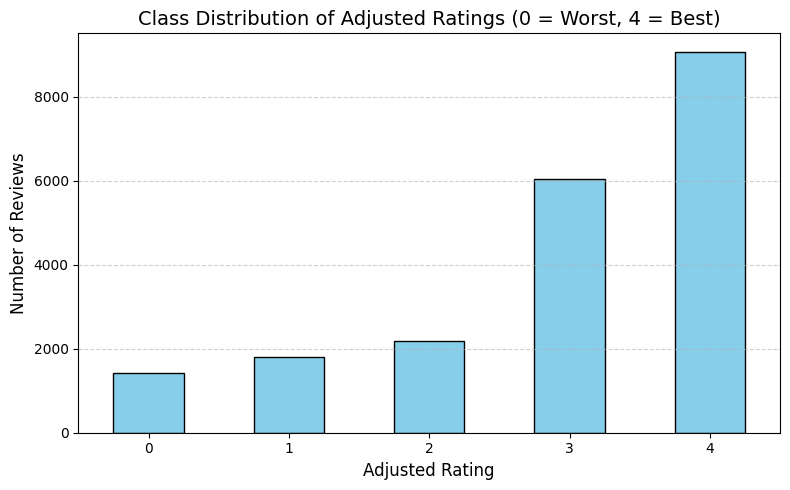

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
df['Rating_Adjusted'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Class Distribution of Adjusted Ratings (0 = Worst, 4 = Best)', fontsize=14)
plt.xlabel('Adjusted Rating', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = {
 'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am',
 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been',
 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can',
 'd', 'did', 'do', 'does', 'doing', 'down', 'during', 'each', 'few',
 'for', 'from', 'further', 'had', 'has', 'have', 'having', 'he',
 "he'd", "he'll", "he's", 'her', 'here', 'hers', 'herself', 'him',
 'himself', 'his', 'how', 'i', "i'd", "i'll", "i'm", "i've", 'if',
 'in', 'into', 'is', 'it', "it'd", "it'll", "it's", 'its', 'itself',
 'just', 'll', 'm', 'ma', 'me', 'more', 'most', 'my', 'myself', 'now',
 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our',
 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'she',
 "she'd", "she'll", "she's", 'should', "should've", 'so', 'some',
 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs',
 'them', 'themselves', 'then', 'there', 'these', 'they', "they'd",
 "they'll", "they're", "they've", 'this', 'those', 'through', 'to',
 'too', 'under', 'until', 'up', 've', 'very', 'was', 'we', "we'd",
 "we'll", "we're", "we've", 'were', 'what', 'when', 'where', 'which',
 'while', 'who', 'whom', 'why', 'will', 'with', 'y', 'you', "you'd",
 "you'll", "you're", "you've", 'your', 'yours', 'yourself',
 'yourselves'
}

In [ ]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = contractions.fix(text) # Expand contractions first
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation

    words = text.split()
    cleaned_words = [word for word in words if word not in stop_words and len(word)>1]
    return " ".join(cleaned_words)

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def displayRatingWordClouds(reviewColumn="Review"):
  df_1=df[df["Rating"]==1]
  df_2=df[df["Rating"]==2]
  df_3=df[df["Rating"]==3]
  df_4=df[df["Rating"]==4]
  df_5=df[df["Rating"]==5]
  fig, axes = plt.subplots(1, 5, figsize=(30, 15))

  rating_dfs = [df_1, df_2, df_3, df_4, df_5]
  ratings = [1, 2, 3, 4, 5]

  for i, (df_rating, rating) in enumerate(zip(rating_dfs, ratings)):
      wc = WordCloud(max_words=1000, min_font_size=10, height=800, width=800, background_color="white")
      wc.generate(' '.join(df_rating[reviewColumn]))
      axes[i].imshow(wc)
      axes[i].set_title(f'Rating: {rating}', fontsize=20)
      axes[i].axis('off')  # Hide axes

  plt.tight_layout()
  plt.show()

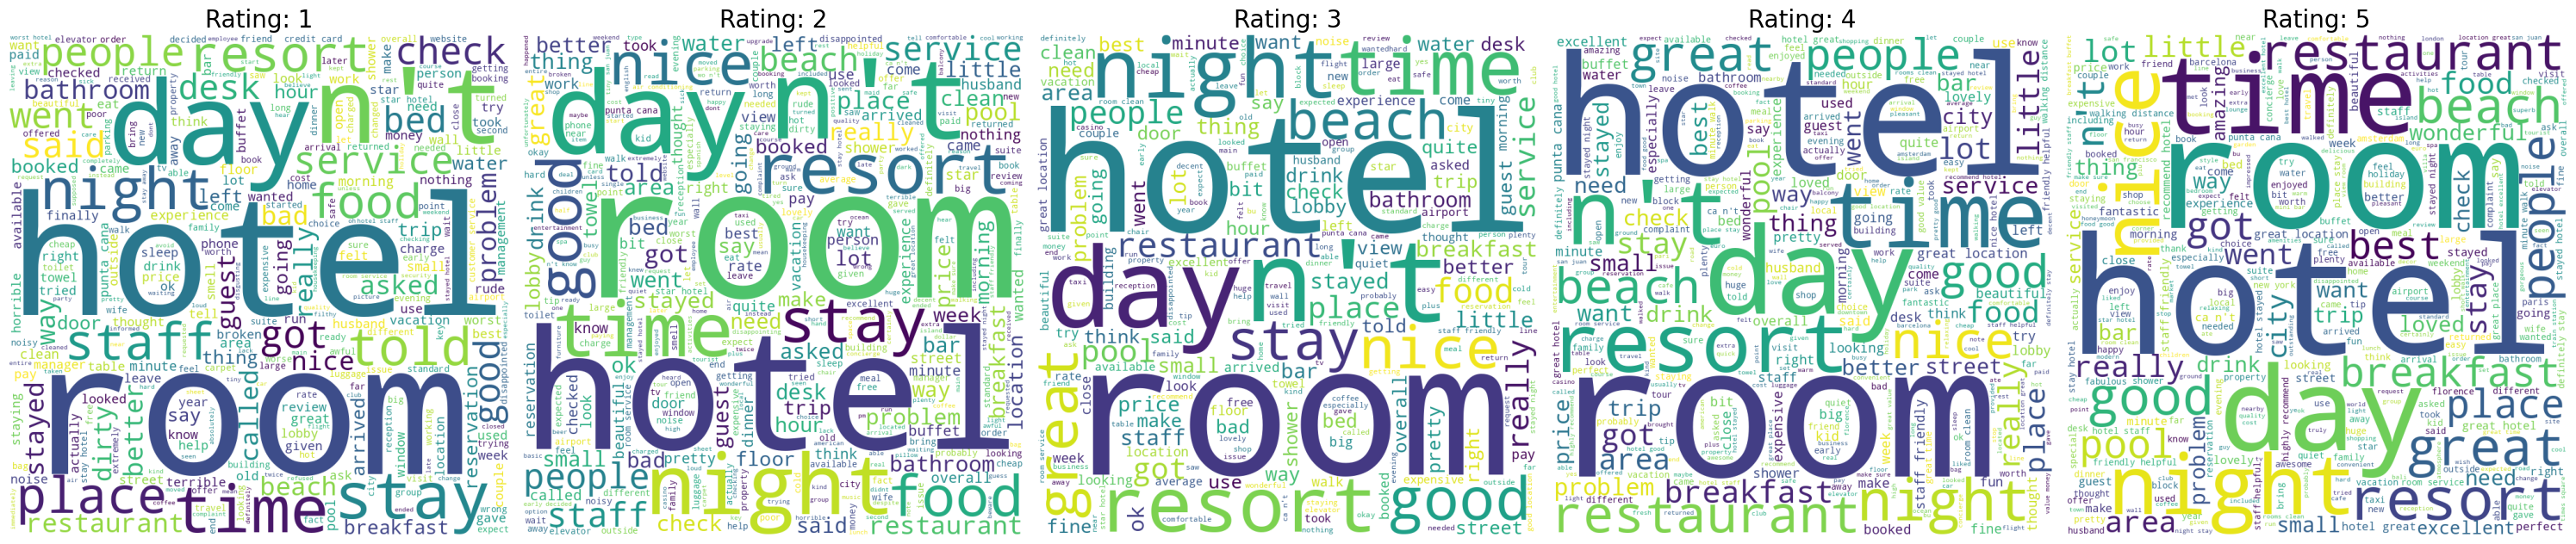

In [ ]:
#Before removing the stop words.
displayRatingWordClouds();

In [ ]:
custom_stopwords = {"hotel", "room", "day", "night", "time", "resort", "stay"}
stop_words.update(custom_stopwords)

df['Cleaned_Review'] = df[review_col_name].apply(preprocess_text)
print("\nSample of cleaned reviews:")
print(df[[review_col_name, 'Cleaned_Review']].head())



Sample of cleaned reviews:
                                              Review  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                      Cleaned_Review  
0  nice expensive parking got good deal anniversa...  
1  ok nothing special charge diamond member hilto...  
2  nice rooms not experience monaco seattle good ...  
3  unique great wonderful monaco location excelle...  
4  great great went seahawk game awesome downfall...  


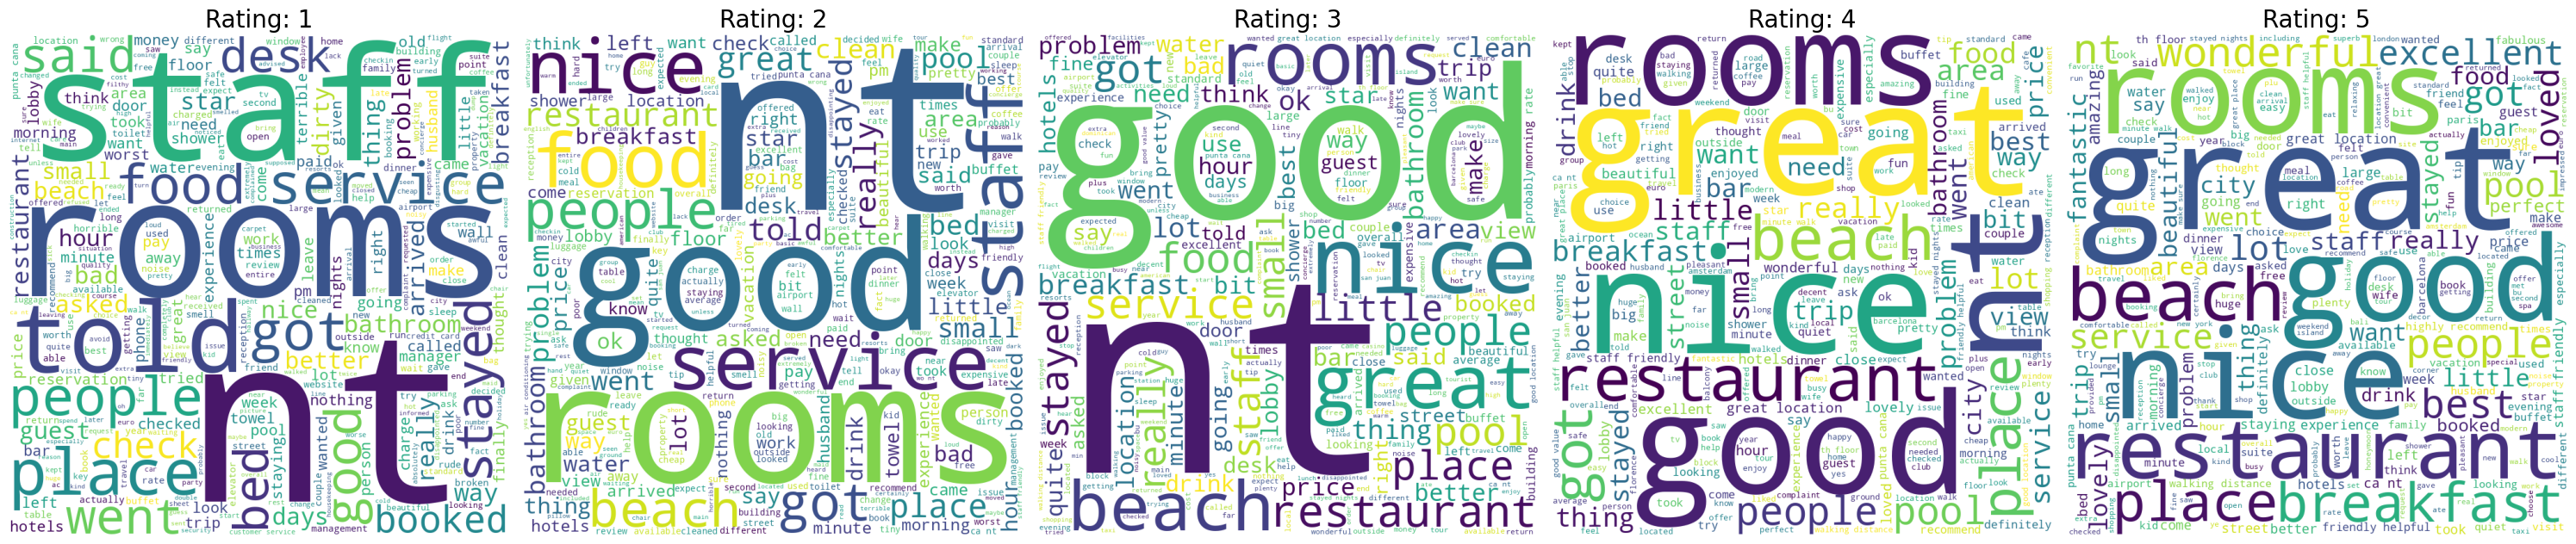

In [ ]:
displayRatingWordClouds(reviewColumn="Cleaned_Review");

<Figure size 2500x1200 with 0 Axes>

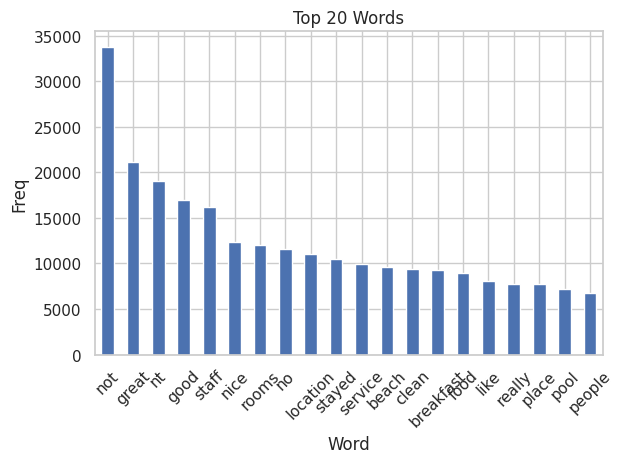

In [ ]:
all_cleaned_text = " ".join(df['Cleaned_Review'].dropna())
words = all_cleaned_text.split()

word_counts = Counter(words)
most_common_words = word_counts.most_common(20)
plt.figure(figsize=(25, 12)); pd.DataFrame(most_common_words, columns=['Word', 'Count']).set_index('Word').plot(kind='bar', legend=False)
plt.title('Top 20 Words'); plt.ylabel('Freq'); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


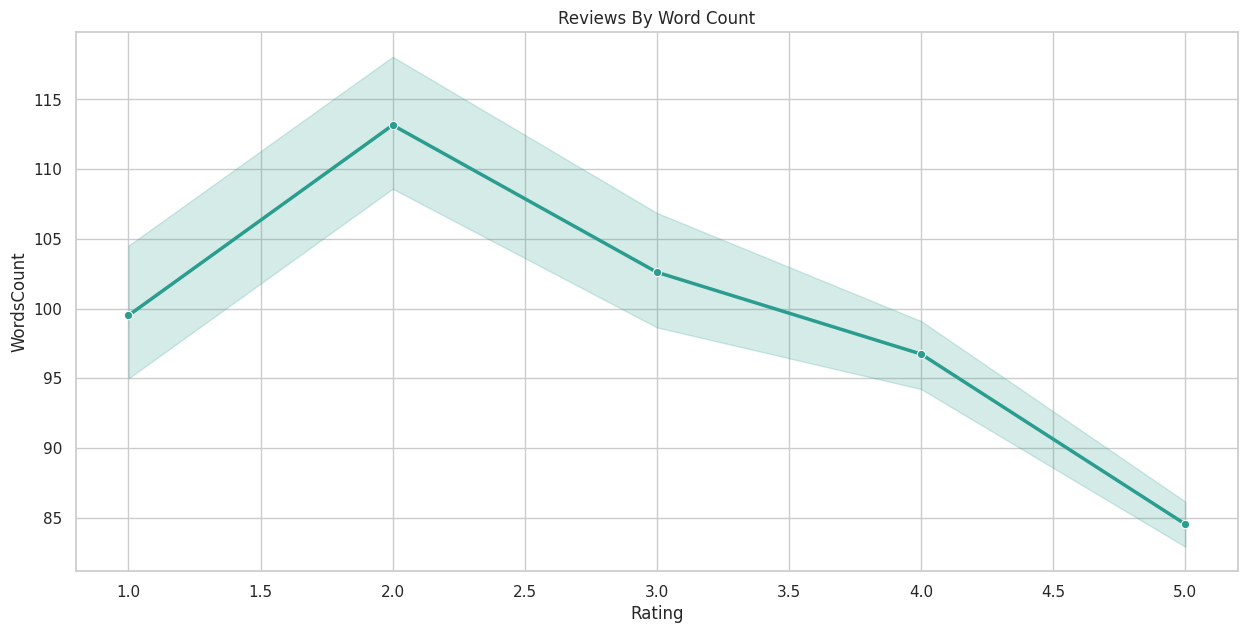

In [ ]:
import seaborn as sns

def getWordsCount(text):
  return len(text.split())

df['WordsCount'] = df['Cleaned_Review'].apply(getWordsCount)
sns.set_theme(style="whitegrid")

plt.figure(figsize=(15,7))
plt.title("Reviews By Word Count")
sns.lineplot(data=df, x="Rating", y="WordsCount", color="#2a9d8f", marker="o", linewidth=2.5)
plt.show()

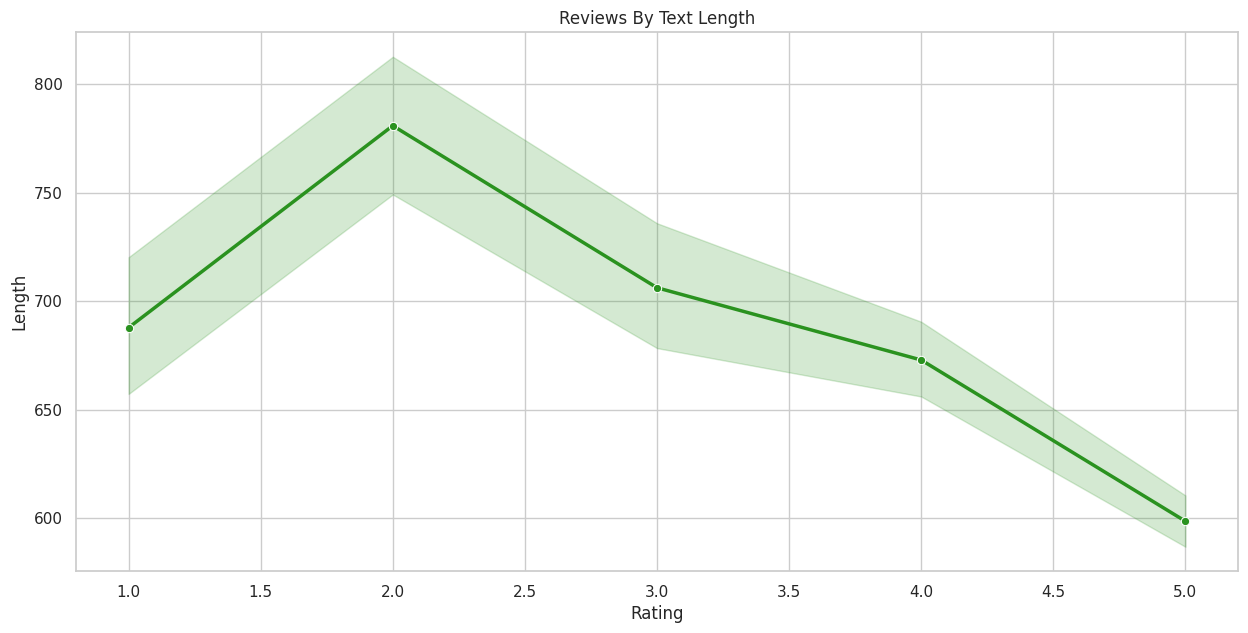

In [ ]:
import seaborn as sns
df['Length'] = df['Cleaned_Review'].apply(len)
df.head()

plt.figure(figsize=(15,7))
plt.title("Reviews By Text Length")
sns.lineplot(data=df, x="Rating", y="Length",  color="#2a921f", marker="o", linewidth=2.5)
plt.show()

In [ ]:
X_train_padded, X_val_padded, X_test_padded = np.array([]), np.array([]), np.array([])
y_train_categorical, y_val_categorical, y_test_categorical = np.array([]), np.array([]), np.array([])
y_train_full_orig, y_val_orig, y_test_orig = np.array([]), np.array([]), np.array([]) # For original test labels
NUM_CLASSES = 0
MAX_LENGTH = 0
tokenizer = None
word_index = {}

In [ ]:
X = df['Cleaned_Review'].values
y = df['Rating_Adjusted'].values

X_train_full_orig, X_temp, y_train_full_orig, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # Stratify on original y
)
X_val_orig, X_test_orig, y_val_orig, y_test_orig = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp # Stratify on y_temp
)

print(f"Original split sizes: Train: {len(X_train_full_orig)}, Val: {len(X_val_orig)}, Test: {len(X_test_orig)}")
print(f"Original y_train_full_orig class distribution: {Counter(y_train_full_orig)}")

Original split sizes: Train: 16392, Val: 2049, Test: 2050
Original y_train_full_orig class distribution: Counter({4: 7243, 3: 4831, 2: 1747, 1: 1434, 0: 1137})


In [ ]:
# Keras Tokenizer
VOCAB_SIZE = 10000
OOV_TOKEN = "<OOV>"

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train_full_orig) # Fit tokenizer ONLY on original training text
word_index = tokenizer.word_index
print(f"\nFound {len(word_index)} unique tokens.")


Found 64980 unique tokens.


In [ ]:
# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train_full_orig)
X_val_sequences = tokenizer.texts_to_sequences(X_val_orig)
X_test_sequences = tokenizer.texts_to_sequences(X_test_orig)

# Padding
sequence_lengths = [len(s) for s in X_train_sequences]

MAX_LENGTH_PERCENTILE = 95
MAX_LENGTH = int(np.percentile(sequence_lengths, MAX_LENGTH_PERCENTILE))
MAX_LENGTH = max(1, MAX_LENGTH)
print(f"\nMax sequence length ({MAX_LENGTH_PERCENTILE}th percentile): {MAX_LENGTH}")

PADDING_TYPE, TRUNCATING_TYPE = 'post', 'post'
X_train_padded_orig = pad_sequences(X_train_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)
X_val_padded = pad_sequences(X_val_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE) # Val data is not oversampled
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE) # Test data is not oversampled

print(f"Padded shapes before SMOTE: Train_orig {X_train_padded_orig.shape}, Val {X_val_padded.shape}, Test {X_test_padded.shape}")


Max sequence length (95th percentile): 249
Padded shapes before SMOTE: Train_orig (16392, 249), Val (2049, 249), Test (2050, 249)


In [ ]:
print("\nApplying SMOTE to training data...")
smote = SMOTE(random_state=42) # Default k_neighbors=5. Adjust if smallest class is < 6.

# Check if k_neighbors needs adjustment
min_class_count_train = min(Counter(y_train_full_orig).values())
if min_class_count_train <= smote.k_neighbors:
    new_k = max(1, min_class_count_train - 1)
    print(f"Adjusting SMOTE k_neighbors from {smote.k_neighbors} to {new_k} due to small class size in training data.")
    smote.k_neighbors = new_k

if smote.k_neighbors > 0:
    try:
        X_train_padded, y_train_full_smote = smote.fit_resample(X_train_padded_orig, y_train_full_orig)
        print("SMOTE applied successfully.")
        print(f"Padded shapes after SMOTE: Train {X_train_padded.shape}")
        print(f"y_train_full_smote class distribution after SMOTE: {Counter(y_train_full_smote)}")
    except ValueError as e:
        print(f"Error during SMOTE: {e}. Using original training data without SMOTE.")
        X_train_padded = X_train_padded_orig
        y_train_full_smote = y_train_full_orig # Fallback
else:
    print("SMOTE k_neighbors is 0 or less. Using original training data without SMOTE.")
    X_train_padded = X_train_padded_orig
    y_train_full_smote = y_train_full_orig # Fallback



Applying SMOTE to training data...
SMOTE applied successfully.
Padded shapes after SMOTE: Train (36215, 249)
y_train_full_smote class distribution after SMOTE: Counter({4: 7243, 3: 7243, 1: 7243, 2: 7243, 0: 7243})


In [ ]:
NUM_CLASSES = len(np.unique(y)) # Based on all unique ratings in original y from df
print(f"Number of unique classes (ratings): {NUM_CLASSES}")

if NUM_CLASSES > 0:
    # One-hot encode the target variables
    y_train_categorical = to_categorical(y_train_full_smote, num_classes=NUM_CLASSES) # Use SMOTE'd y_train
    y_val_categorical = to_categorical(y_val_orig, num_classes=NUM_CLASSES)
    y_test_categorical = to_categorical(y_test_orig, num_classes=NUM_CLASSES)
    print(f"Shape of one-hot y_train (after SMOTE if applied): {y_train_categorical.shape}")
    # For classification report, we need original y_test labels (not one-hot)
    # y_test variable is already y_test_orig from the split.
else:
    print("Error: NUM_CLASSES is 0, cannot one-hot encode.")


Number of unique classes (ratings): 5
Shape of one-hot y_train (after SMOTE if applied): (36215, 5)


In [ ]:

# class_weight_dict = None # Initialize
# if not df.empty and 'Rating_Adjusted' in df.columns and y_train_full.size > 0 and NUM_CLASSES > 0:
#     # Calculate class weights based on the y_train_full (original 0-4 labels before one-hot encoding)
#     class_weights_values = class_weight.compute_class_weight(
#         class_weight='balanced',
#         classes=np.unique(y_train_full), # Ensure classes are from training set distribution
#         y=y_train_full
#     )
#     class_weight_dict = dict(enumerate(class_weights_values))
#     print("Calculated Class Weights:")
#     print(class_weight_dict)
# else:
#     print("Skipping class weight calculation (data not processed, y_train_full empty, or NUM_CLASSES=0).")

In [ ]:

EMBEDDING_DIM = 64
model_rnn, model_lstm, model_lstm_w2v = None, None, None # Initialize


def build_simple_rnn_model(vocab_size, embedding_dim, max_length, num_classes):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        SimpleRNN(64), Dropout(0.5), Dense(32, activation='relu'), Dropout(0.5),
        Dense(num_classes, activation='softmax')])
    return model

In [ ]:
if NUM_CLASSES > 0 and MAX_LENGTH > 0:
    model_rnn = build_simple_rnn_model(VOCAB_SIZE, EMBEDDING_DIM, MAX_LENGTH, NUM_CLASSES)
    model_rnn.summary()
else: print("Skipping Simple RNN model build (NUM_CLASSES or MAX_LENGTH is 0).")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_bidirectional_lstm_model(vocab_size, embedding_dim, max_length, num_classes):
    print("Building IMPROVED Bidirectional LSTM model...")
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        Bidirectional(LSTM(128, return_sequences=False)), # Increased LSTM units to 128
        Dropout(0.5), # Adjusted dropout
        Dense(128, activation='relu'), # Added another dense layer, increased units
        Dropout(0.5), # Dropout for the new dense layer
        Dense(64, activation='relu'),   # Kept original dense layer
        Dropout(0.4),                   # Dropout for this dense layer
        Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
if NUM_CLASSES > 0 and MAX_LENGTH > 0:
    model_lstm = build_bidirectional_lstm_model(VOCAB_SIZE, EMBEDDING_DIM, MAX_LENGTH, NUM_CLASSES)
    model_lstm.summary()
else:
    model_lstm = None # Ensure model_lstm is None if not built
    print("Skipping Bidirectional LSTM model build (NUM_CLASSES or MAX_LENGTH is 0).")

Building IMPROVED Bidirectional LSTM model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# gensim_embedding_model = None
# PRETRAINED_EMBEDDING_DIM = 50

In [ ]:
# if NUM_CLASSES > 0 and MAX_LENGTH > 0:
#     try:
#         PRETRAINED_EMBEDDING_NAME = 'glove-wiki-gigaword-50'
#         print(f"Loading {PRETRAINED_EMBEDDING_NAME}..."); gensim_embedding_model = api.load(PRETRAINED_EMBEDDING_NAME)
#         PRETRAINED_EMBEDDING_DIM = gensim_embedding_model.vector_size
#         print(f"{PRETRAINED_EMBEDDING_NAME} loaded. Vector size: {PRETRAINED_EMBEDDING_DIM}")
#     except Exception as e:
#         print(f"Error loading pretrained embeddings: {e}. Skipping Model 3."); gensim_embedding_model = None
# else: print("Skipping Word2Vec loading (NUM_CLASSES or MAX_LENGTH is 0).")

In [ ]:
import gensim.downloader as api # For Word2Vec

gensim_embedding_model = None
embedding_matrix = None

PRETRAINED_EMBEDDING_NAME = 'fasttext-wiki-news-subwords-300'

print(f"Loading {PRETRAINED_EMBEDDING_NAME} for Word Embeddings...")
print("This may take a few minutes for the first download...")
gensim_embedding_model = api.load(PRETRAINED_EMBEDDING_NAME)
PRETRAINED_EMBEDDING_DIM = gensim_embedding_model.vector_size # Get dimension from loaded model
print(f"{PRETRAINED_EMBEDDING_NAME} loaded. Vector size: {PRETRAINED_EMBEDDING_DIM}")


Loading fasttext-wiki-news-subwords-300 for Word Embeddings...
This may take a few minutes for the first download...
[==================================================] 100.0% 958.5/958.4MB downloaded
fasttext-wiki-news-subwords-300 loaded. Vector size: 300


In [ ]:

# Create embedding matrix
print(f"Creating embedding matrix with V_S={VOCAB_SIZE}, P_E_D={PRETRAINED_EMBEDDING_DIM}")
embedding_matrix = np.zeros((VOCAB_SIZE, PRETRAINED_EMBEDDING_DIM))
words_found = 0
words_oov_vector_generated = 0 # To count how many OOV words FastText generated vectors for

for word, idx in word_index.items():
    if idx < VOCAB_SIZE: # Only consider words within our tokenizer's vocab size
        try:
            embedding_matrix[idx] = gensim_embedding_model[word]
            words_found += 1
        except KeyError:
            pass

print(f"FastText: Created/Found embeddings for {words_found}/{min(len(word_index), VOCAB_SIZE)} words in vocab.")
# print(f"FastText: (Optional detail) Truly found: {words_found}, Generated for OOV: {words_oov_vector_generated}")

if words_found == 0 and min(len(word_index), VOCAB_SIZE) > 0 : # Check if vocab has words but none were embedded
    print("Warning: No words from your vocab were embedded by FastText. Embedding matrix will be all zeros.")
    # embedding_matrix = None # Or handle this case appropriately; matrix is already zeros


Creating embedding matrix with V_S=10000, P_E_D=300
FastText: Created/Found embeddings for 9252/10000 words in vocab.


In [ ]:
# Create embedding matrix using Word2Vec
print(f"Creating embedding matrix with size ({VOCAB_SIZE}, {PRETRAINED_EMBEDDING_DIM})...")
embedding_matrix = np.zeros((VOCAB_SIZE, PRETRAINED_EMBEDDING_DIM))
words_found = 0

for word, idx in word_index.items():
    if idx < VOCAB_SIZE:  # Only process words that are in our vocabulary limit
        try:
            embedding_vector = gensim_embedding_model[word]
            embedding_matrix[idx] = embedding_vector
            words_found += 1
        except KeyError:
            # Word not in embedding model vocabulary, leave as zeros
            pass

    print(f"Found embeddings for {words_found}/{min(len(word_index), VOCAB_SIZE)} words.")

Streaming output truncated to the last 5000 lines.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddings for 9252/10000 words.
Found embeddi

In [ ]:
def build_bidirectional_lstm_word2vec_model(vocab_size_tok, emb_dim_pre, max_len_seq, num_cls_ds, emb_matrix_pre):
    print("Building IMPROVED Bidirectional LSTM model with Word2Vec...")
    model = Sequential([
        Embedding(input_dim=vocab_size_tok,
                output_dim=emb_dim_pre,
                input_length=max_len_seq,
                weights=[emb_matrix_pre],
                trainable=False), # Keep trainable=False for now, can be a separate experiment
        Bidirectional(LSTM(128, return_sequences=False)), # Increased LSTM units
        Dropout(0.5),
        Dense(128, activation='relu'), # Added dense layer
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(num_cls_ds, activation='softmax')
    ])
    return model

model_lstm_w2v = build_bidirectional_lstm_word2vec_model(VOCAB_SIZE, PRETRAINED_EMBEDDING_DIM, MAX_LENGTH, NUM_CLASSES, embedding_matrix)
model_lstm_w2v.summary()

Building IMPROVED Bidirectional LSTM model with Word2Vec...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

In [ ]:
EPOCHS = 50
BATCH_SIZE = 32
PATIENCE_EARLY_STOPPING = 5
LEARNING_RATE = 0.00003

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE_EARLY_STOPPING, restore_best_weights=True)
model_results = {}
trained_model_rnn, trained_model_lstm, trained_model_lstm_w2v = None, None, None

In [ ]:
def train_and_evaluate_model(model, model_name,
                             X_train, y_train, X_val, y_val,
                             X_test_data, y_test_original_labels_param, y_test_one_hot,
                             num_classes_local, learning_rate_param=LEARNING_RATE,
                             epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks_list=None):

    if callbacks_list is None: callbacks_list = [early_stopping]

    print(f"\n--- Training {model_name} with learning rate: {learning_rate_param} ---")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_param)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), callbacks=callbacks_list,
                        verbose=1)

    print(f"\n--- Evaluating {model_name} on Test Set ---")
    loss, accuracy = model.evaluate(X_test_data, y_test_one_hot, verbose=0)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
    y_pred_probs = model.predict(X_test_data); y_pred_classes = np.argmax(y_pred_probs, axis=1)
    print("\nClassification Report:"); target_names = [f"Rating {i+1}" for i in range(num_classes_local)]

    print(classification_report(y_test_original_labels_param, y_pred_classes, target_names=target_names, zero_division=0))

    # Create confusion matrix and display as heatmap
    cm = confusion_matrix(y_test_original_labels_param, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()

    # Display training history plots
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return accuracy, history, model


Training Model 1: Simple RNN

--- Training Simple RNN with learning rate: 3e-05 ---
Epoch 1/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.1951 - loss: 1.6171 - val_accuracy: 0.0971 - val_loss: 1.6224
Epoch 2/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.1979 - loss: 1.6136 - val_accuracy: 0.1489 - val_loss: 1.6126
Epoch 3/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.2016 - loss: 1.6103 - val_accuracy: 0.1957 - val_loss: 1.6118
Epoch 4/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.2113 - loss: 1.6082 - val_accuracy: 0.2855 - val_loss: 1.6062
Epoch 5/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - accuracy: 0.2115 - loss: 1.6074 - val_accuracy: 0.3353 - val_loss: 1.6053
Epoch 6/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.2169 - loss: 1.6063 - val_accuracy: 0.2811 - val_loss: 1.6052
Epoch 7/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.2295 - loss: 1.6014 - val_accuracy: 0.3221 - val_loss

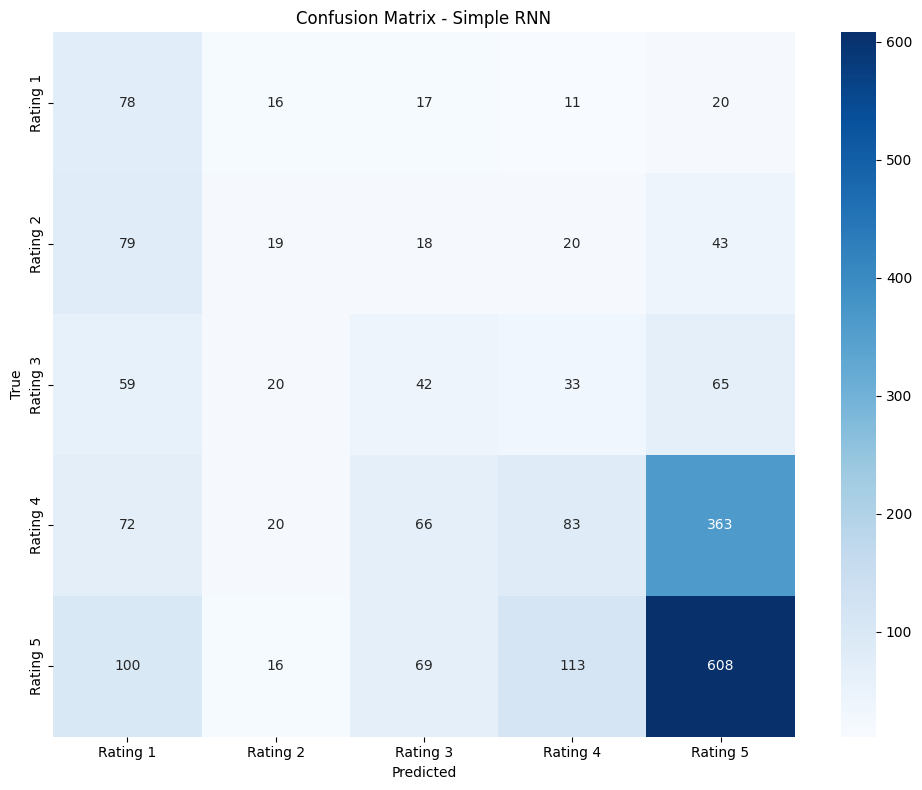

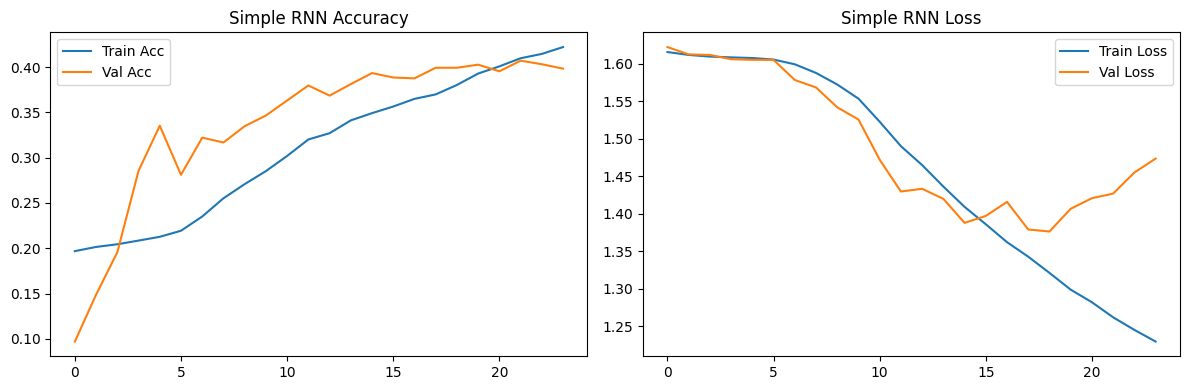

In [ ]:
# Train Model 1: Simple RNN
if model_rnn and X_train_padded.size > 0:
    print("\nTraining Model 1: Simple RNN")
    # y_test_orig should be the original integer labels of your test set
    acc_rnn, hist_rnn, trained_model_rnn = train_and_evaluate_model(
        model_rnn, "Simple RNN", X_train_padded, y_train_categorical, X_val_padded, y_val_categorical,
        X_test_padded, y_test_orig, y_test_categorical, NUM_CLASSES) # y_test_orig is used for report
    if acc_rnn > 0: model_results["Simple RNN"] = acc_rnn
else: print("Skipping Simple RNN training.")


Training Model 2: Bidirectional LSTM

--- Training Bidirectional LSTM with learning rate: 3e-05 ---
Epoch 1/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.2059 - loss: 1.6090 - val_accuracy: 0.4427 - val_loss: 1.5835
Epoch 2/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.2917 - loss: 1.5548 - val_accuracy: 0.4612 - val_loss: 1.2728
Epoch 3/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.3517 - loss: 1.3867 - val_accuracy: 0.4934 - val_loss: 1.1363
Epoch 4/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.3717 - loss: 1.3197 - val_accuracy: 0.4968 - val_loss: 1.1010
Epoch 5/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.3886 - loss: 1.2777 - val_accuracy: 0.5217 - val_loss: 1.0581
Epoch 6/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.4045 - loss: 1.2430 - val_accuracy: 0.5344 - val_loss: 1.0279
Epoch 7/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.4120 - loss: 1.2127 - val_accuracy: 0

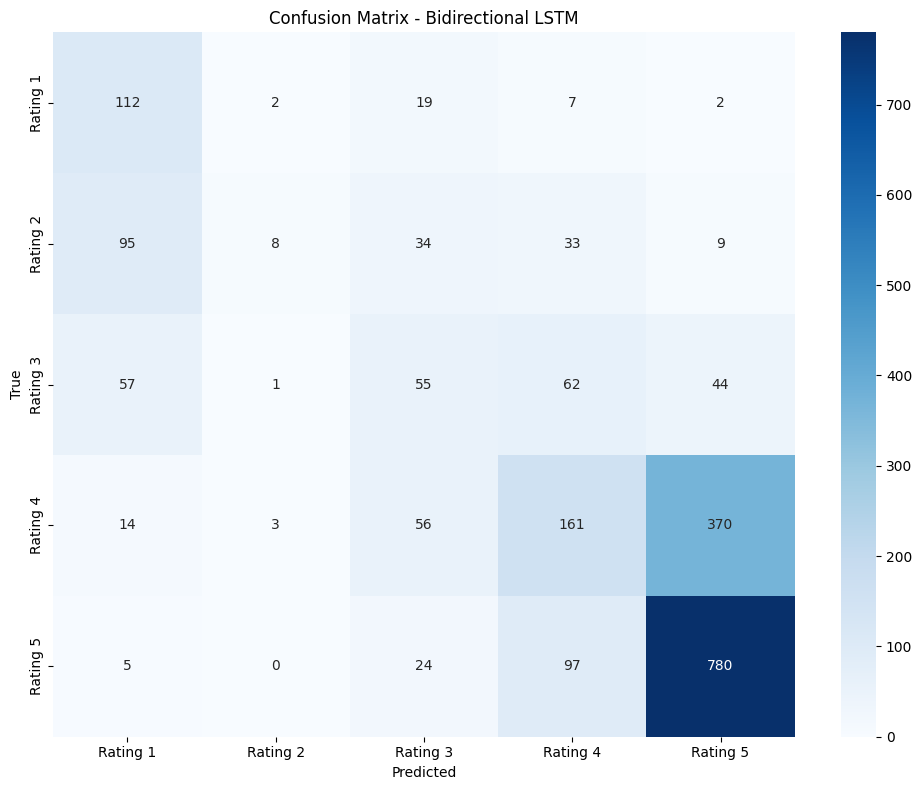

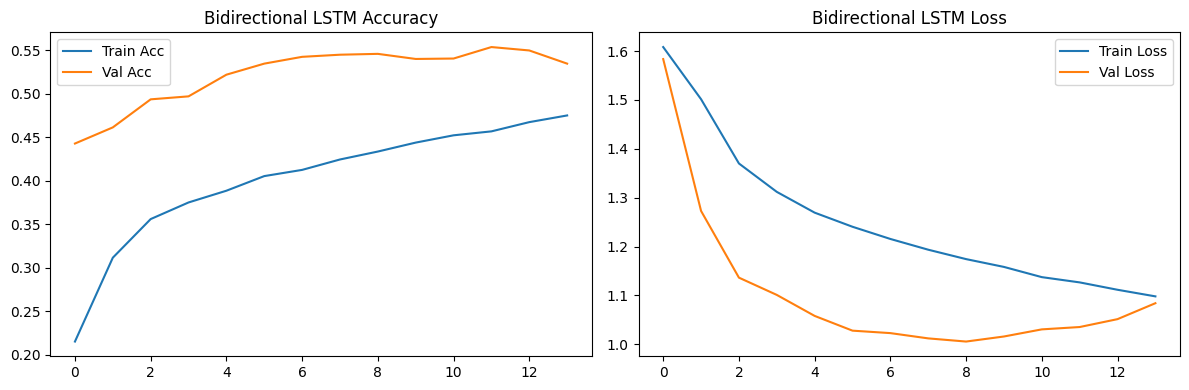

In [ ]:
# Train Model 2: Bidirectional LSTM
if model_lstm and X_train_padded.size > 0:
    print("\nTraining Model 2: Bidirectional LSTM")
    acc_lstm, hist_lstm, trained_model_lstm = train_and_evaluate_model(
        model_lstm, "Bidirectional LSTM", X_train_padded, y_train_categorical, X_val_padded, y_val_categorical,
        X_test_padded, y_test_orig, y_test_categorical, NUM_CLASSES)
    if acc_lstm > 0: model_results["Bidirectional LSTM"] = acc_lstm
else: print("Skipping Bidirectional LSTM training.")


Training Model 3: Bidirectional LSTM with Word2Vec

--- Training Bidirectional LSTM with Word2Vec with learning rate: 3e-05 ---
Epoch 1/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.2134 - loss: 1.6067 - val_accuracy: 0.4222 - val_loss: 1.5750
Epoch 2/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.3057 - loss: 1.5326 - val_accuracy: 0.4553 - val_loss: 1.2217
Epoch 3/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.3484 - loss: 1.3946 - val_accuracy: 0.4773 - val_loss: 1.1636
Epoch 4/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.3640 - loss: 1.3505 - val_accuracy: 0.4724 - val_loss: 1.1933
Epoch 5/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.3746 - loss: 1.3227 - val_accuracy: 0.4993 - val_loss: 1.0990
Epoch 6/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.3866 - loss: 1.3064 - val_accuracy: 0.5076 - val_loss: 1.0908
Epoch 7/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.3889 - lo

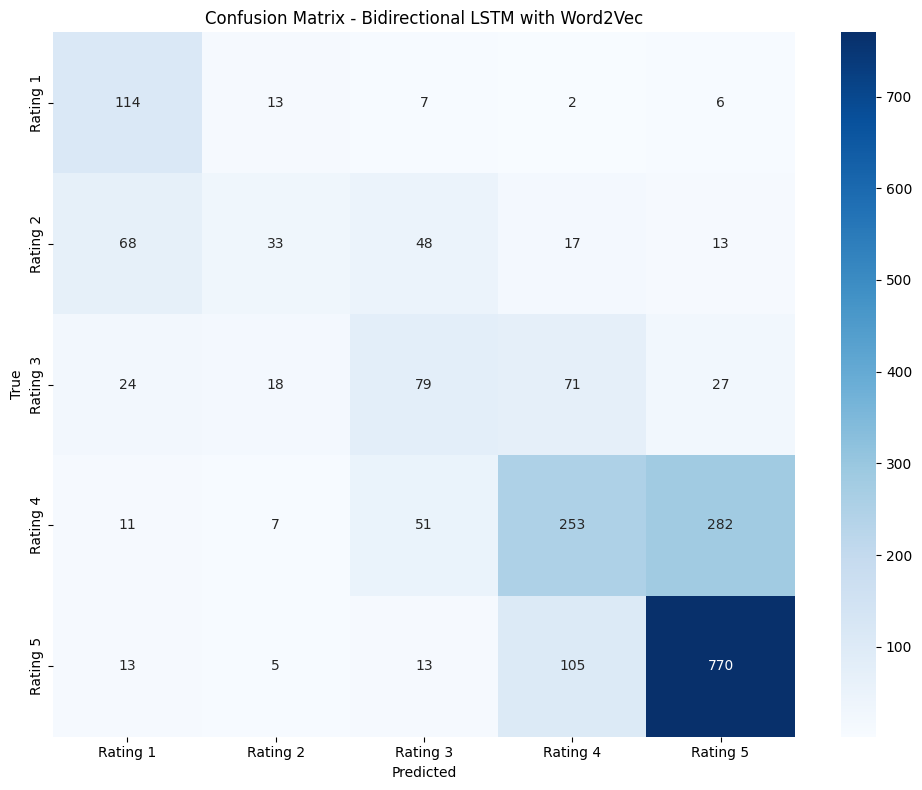

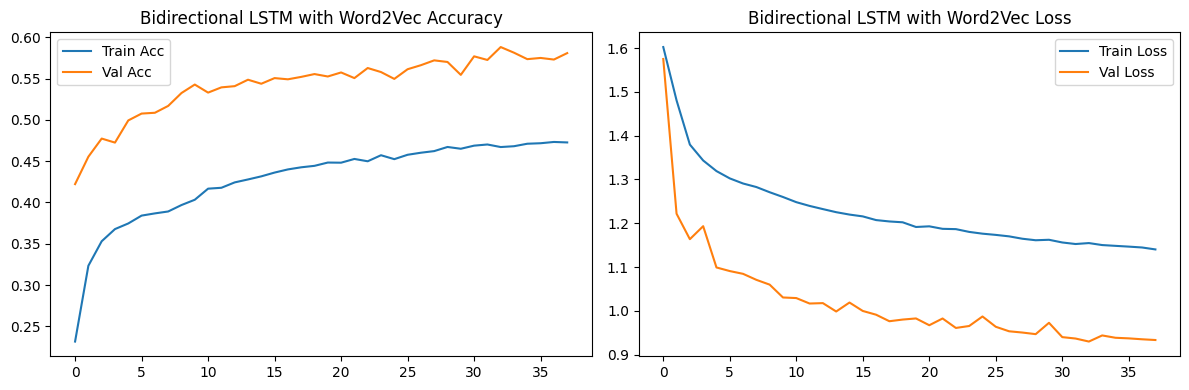

In [ ]:
# Train Model 3: Bidirectional LSTM with Word2Vec
if model_lstm_w2v and X_train_padded.size > 0:
    print("\nTraining Model 3: Bidirectional LSTM with Word2Vec")
    acc_lstm_w2v, hist_lstm_w2v, trained_model_lstm_w2v = train_and_evaluate_model(
        model_lstm_w2v, "Bidirectional LSTM with Word2Vec", X_train_padded, y_train_categorical, X_val_padded, y_val_categorical,
        X_test_padded, y_test_orig, y_test_categorical, NUM_CLASSES)
    if acc_lstm_w2v > 0: model_results["Bidirectional LSTM with Word2Vec"] = acc_lstm_w2v
else: print("Skipping Bidirectional LSTM with Word2Vec training.")

In [ ]:
print(f"Creating embedding matrix with size ({VOCAB_SIZE}, {PRETRAINED_EMBEDDING_DIM})...")
embedding_matrix = np.zeros((VOCAB_SIZE, PRETRAINED_EMBEDDING_DIM))
words_found = 0

for word, idx in word_index.items():
    if idx < VOCAB_SIZE:  # Only process words that are in our vocabulary limit
        try:
            embedding_vector = gensim_embedding_model[word]
            embedding_matrix[idx] = embedding_vector
            words_found += 1
        except KeyError:
            # Word not in embedding model vocabulary, leave as zeros
            pass

print(f"Found embeddings for {words_found}/{min(len(word_index), VOCAB_SIZE)} words.")


Creating embedding matrix with size (10000, 300)...
Found embeddings for 9252/10000 words.


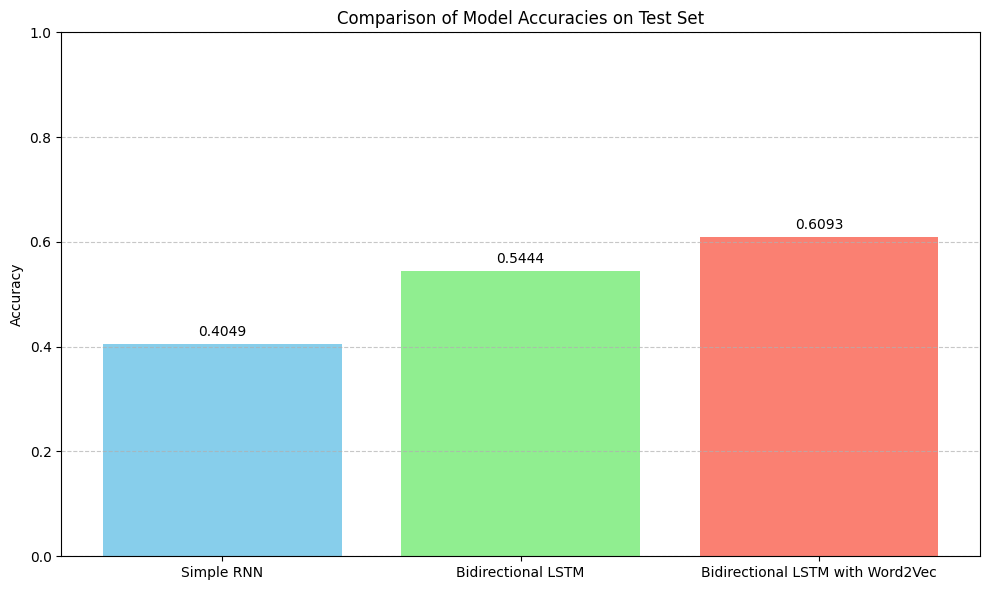

In [ ]:
import matplotlib.pyplot as plt

models = list(model_results.keys())
accuracies = list(model_results.values())

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies on Test Set')
plt.ylim(0, 1.0) # Set y-axis limits from 0 to 1 for accuracy
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()



In [ ]:
import gradio as gr # For the GUI
best_model_for_gui = None
best_model_name_for_gui = None

for name, acc in model_results.items():
    print(f"{name}: {acc:.4f}")

best_model_name_for_gui = max(model_results, key=model_results.get)
print(f"\nBest model based on accuracy: {best_model_name_for_gui} with accuracy {model_results[best_model_name_for_gui]:.4f}")

if best_model_name_for_gui == "Simple RNN":
    best_model_for_gui = trained_model_rnn
    print(f"Selected '{best_model_name_for_gui}' for GUI.")
elif best_model_name_for_gui == "Bidirectional LSTM":
    best_model_for_gui = trained_model_lstm
    print(f"Selected '{best_model_name_for_gui}' for GUI.")
elif best_model_name_for_gui == "Bidirectional LSTM with Word2Vec":
    best_model_for_gui = trained_model_lstm_w2v
    print(f"Selected '{best_model_name_for_gui}' for GUI.")
else:
    print(f"Warning: Best model '{best_model_name_for_gui}' was identified, but its trained instance is None. GUI might not work.")
    best_model_for_gui = None # Ensure it's None if the instance is missing

if best_model_for_gui is None:
    print("Could not select a valid trained model for the GUI.")

Simple RNN: 0.4049
Bidirectional LSTM: 0.5444
Bidirectional LSTM with Word2Vec: 0.6093

Best model based on accuracy: Bidirectional LSTM with Word2Vec with accuracy 0.6093
Selected 'Bidirectional LSTM with Word2Vec' for GUI.


In [ ]:
# prompt: save the models into their respective files

trained_model_rnn.save('simple_rnn_model.h5')
trained_model_lstm.save('bidirectional_lstm_model.h5')
trained_model_lstm_w2v.save('bidirectional_lstm_w2v_model.h5')

print("Models saved successfully.")

Models saved successfully.


In [ ]:
# prompt: load the models from the files to be used in the gui

trained_model_rnn = tf.keras.models.load_model('simple_rnn_model.h5')
trained_model_lstm = tf.keras.models.load_model('bidirectional_lstm_model.h5')
trained_model_lstm_w2v = tf.keras.models.load_model('bidirectional_lstm_w2v_model.h5')

print("Models loaded successfully.")

best_model_for_gui = trained_model_lstm_w2v
best_model_name_for_gui = "Bidirectional LSTM with Word2Vec"

Models loaded successfully.


In [ ]:
def predict_rating_gui(review_text):
    if not best_model_for_gui: return "Model not available."
    if not tokenizer: return "Tokenizer not available."
    if MAX_LENGTH == 0 : return "MAX_LENGTH not set."
    if not review_text.strip(): return "Please enter a review."
    cleaned_text = preprocess_text(review_text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)
    prediction_probs = best_model_for_gui.predict(padded_sequence)
    predicted_class_index = np.argmax(prediction_probs, axis=1)[0]
    predicted_rating = predicted_class_index + 1
    conf_scores_str = "\nConfidence Scores:\n" + "".join([f"Rating {i+1}: {p:.2%}\n" for i, p in enumerate(prediction_probs[0])])
    return f"Predicted Rating: {predicted_rating} (out of 5)\n{conf_scores_str}"

if best_model_for_gui and tokenizer and MAX_LENGTH > 0:
    iface = gr.Interface(fn=predict_rating_gui, inputs=gr.Textbox(lines=5, placeholder="Enter hotel review..."),
                         outputs=gr.Textbox(label="Prediction & Confidence"), title="Hotel Review Sentiment Analyzer",
                         description="Predicts rating (1-5) for a hotel review.")
    print("\nLaunching Gradio GUI...")
    try: iface.launch(share=True)
    except Exception as e: print(f"Gradio launch error: {e}")
else: print("\nGUI cannot launch (model, tokenizer, or MAX_LENGTH missing).")


Launching Gradio GUI...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9f3350cfe80981df2c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
